# Extracellular
Generates data from simulated extracellular recordings for studying with spike sorting etc. We run the same simulation as in DryWetLab, but use extracellular measurements to count spikes and check interspike interval distribution.

In [1]:
%matplotlib nbagg
from tqdm import tqdm_notebook as tqdm
import itertools

import numpy as np
from scipy import stats, signal, ndimage
import scipy.integrate as spint
import scipy.interpolate as spolate 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from colorednoise import powerlaw_psd_gaussian as gen_noise
from braingeneers import drylab

In [2]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# How much stronger inhibitory connections are than excitatory ones.
inhibition_factor = 2

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))

# tau : ms time constant of synaptic current
tau = 20

# Sij : pA total EPSC generated in neuron i when neuron j fires.
mu, sigma = -0.702, 0.9355  # taken from Song (2005).
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
S *= np.median(C / tau)
S[:,Ne:] *= -inhibition_factor
S[Ne:,:Ne] *= 2 # make excitatory input to inhibitory cells stronger

excitatory = np.arange(N) < Ne
inhibitory = np.arange(N) >= Ne

# XY : um planar positions of the cells
XY = 70 * np.random.rand(2,N)

# DryLab MEA
This records data from the organoid with the MEA from braingeneers.drylab, which doesn't have any kind of time delay. It uses the relation $I = C\frac{\mathrm{d}V}{\mathrm{d}t}$ under the assumption that $\mathrm{d}t = 1$. 

In [3]:
tmax = 1001

n = drylab.Organoid(XY=XY, S=S*2, tau=tau,
                    a=a, b=b, c=c, d=d,
                    k=k, C=C, Vr=Vr, Vt=Vt)

n_probes = 8
theta = np.linspace(0, 2*np.pi, num=n_probes+1)[:-1]
points = np.array([np.cos(theta), np.sin(theta)]) * 30 + 35
u = drylab.ElectrodeArray(points=points, activation=None, radius=1)
u.insert(n, Vr, 1/C)

pinks = 50*gen_noise(size=(N,tmax), exponent=1)

n.reset()
V = n.V

VUIs = np.zeros((tmax,3,N))
currents = np.zeros((tmax, N))
states = np.zeros((tmax, n_probes))
for t in tqdm(range(tmax)):
    V, Vprev = n.V, V.copy()
    n.step(pinks[:,t])
    V[V > 30] = 30 # This needs to be capped!
    currents[t,:] = n.C*(Vprev - V)
    states[t,:] = u.Vprobe()


<IPython.core.display.Javascript object>


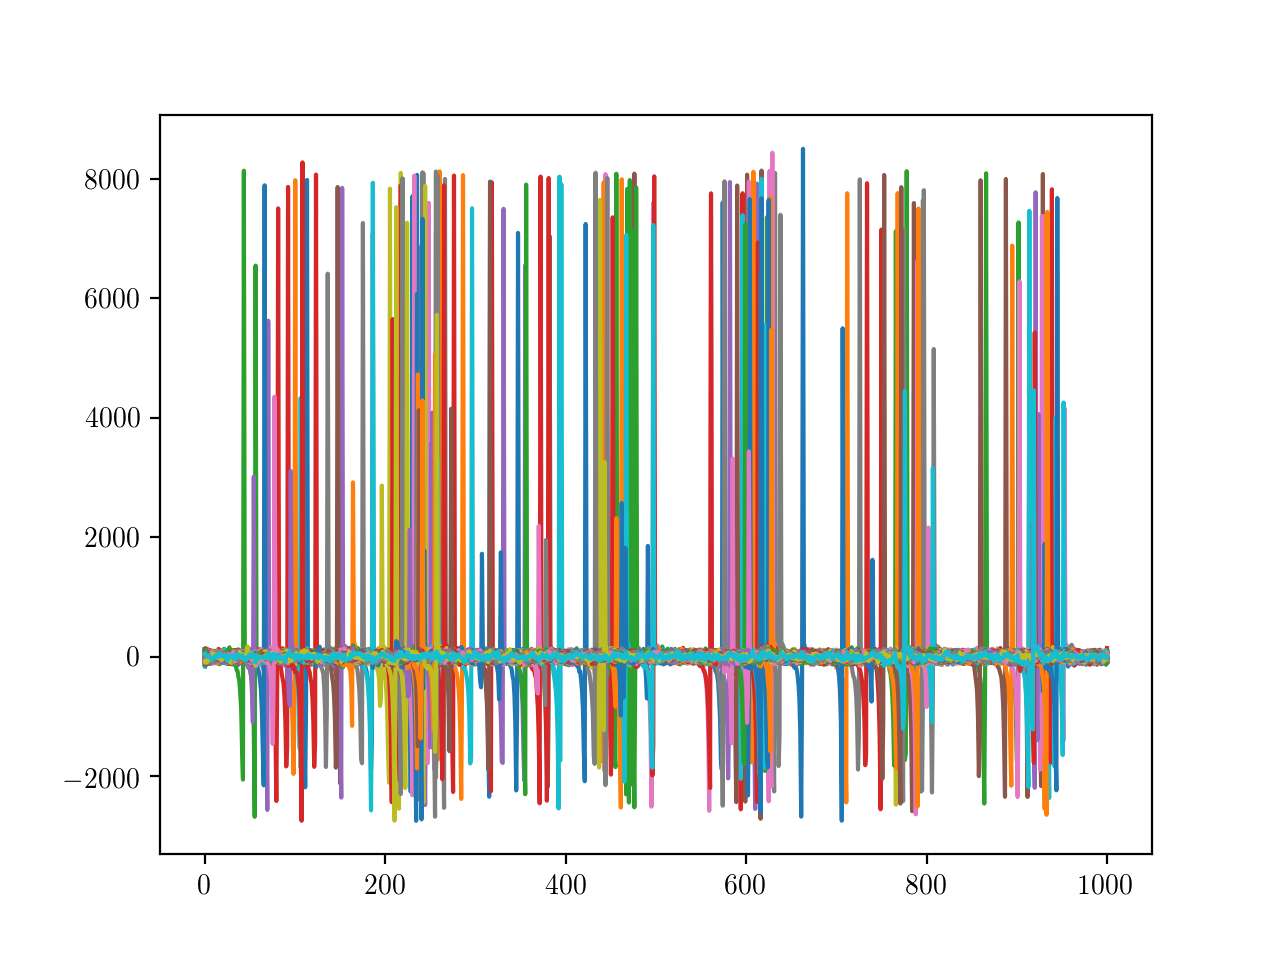

In [4]:
plt.figure()
plt.plot(range(tmax), currents)
None

# Direct Diffusion
Instead of computing this nasty analytic solution that takes forever, let's try propagating the diffusion equation forward in time with a Gaussian blur of radius $D\,\mathrm{d}t$. Time is now quantized, but that shouldn't hurt much. The diffusion constant is the value for $\text{Cl}^-$ from [an online table](https://biofilmbook.hypertextbookshop.com/public_version/artifacts/tables/Module_004/Table4-1_DiffCoeffH2O.htm). This value was chosen because I needed *something* and this is the first electrophysiologically important ion I found a value for.

In [5]:
D = 2 # Diffusion constant, um^2 / ms

# Tensor product grid in micron units.
X = Y = np.linspace(0,70, 21)
dx, dy = X[1] - X[0], Y[1] - Y[0]

# Areal charge distribution, in fC / um^2
rho = np.zeros(X.shape + Y.shape)

# Distance in microns between each probe point 
# and each point of the grid. 
r = np.sqrt((X[:,None] - points[0,:,None,None])**2 +
            (Y[None,:] - points[1,:,None,None])**2)

# Force minimum value to be half the size of a grid
# point since there's no meaning to anything smaller.
min_r = np.sqrt((dx**2 + dy**2))/2
r = np.maximum(r, min_r)

# Assume relative permittivity of water times 
# absolute vacuum permittivity.
eps_factor = 4 * np.pi * 80 * 8.854187e-6 # pF/um

# Quantize each neuron position to the nearest grid point.
XYgrid = np.int32(np.round(XY.T / [dx, dy])).T

# Standard deviation of the Gaussian blur which approximates
# a single timestep of the diffusion process. It should be
# sqrt(D dt), but for the function we're using, it needs to be
# expressed in grid points rather than real units, so divide
# by the grid spacing. (dt is implicitly 1 here.)
sigma = np.sqrt(D)/np.array([dx, dy])

states2 = np.zeros((tmax, n_probes))
for t in tqdm(range(tmax)):
    # Treat the current as a quantity of injected charge, 
    # which must be in fC = pA ms. Then divide by the area
    # of the current grid cell for AREAL charge density.
    indices = zip(XYgrid[0,:], XYgrid[1,:])
    for i,idx in enumerate(indices):
        rho[idx] += currents[t,i] / (dx*dy)
    
    # This Gaussian blur approximates diffusion. Also assume 
    # that charge distribution is neutral outside the region.
    rho = ndimage.gaussian_filter(rho, sigma=sigma, mode='constant')
    
    # For each probe, find the voltage by integrating the point
    # charges contributed by the areal charge density rho.
    states2[t,:] = spint.simps(spint.simps(rho/r, Y), X) / eps_factor

# Sanity Check
Plot the simulation results in terms of both probe voltages and spectrum. We compare the extracellular voltages generated by assuming instantaneous propagation with $1/r$ falloff (in the variable `states`) vs. solving the diffusion equation. Note that the sanity check has been completely failed! The "correct" method in its current state predicts kilovolt extracellular potentials, which are a little hard to justify. 

<IPython.core.display.Javascript object>


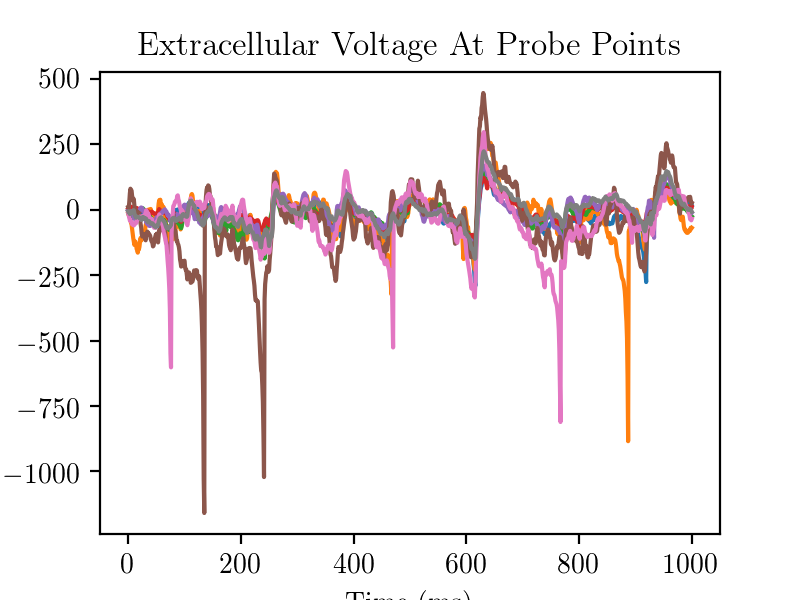

In [7]:
plt.figure(figsize=(4,3))
plt.plot(range(tmax), 1e3*states)
plt.title('Extracellular Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (\\textmu V)')
None

<IPython.core.display.Javascript object>


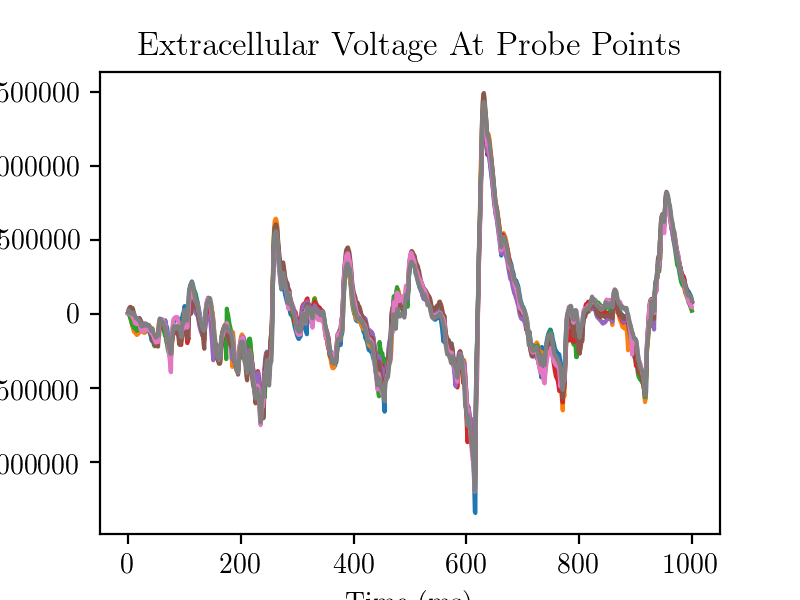

In [9]:
plt.figure(figsize=(4,3))
plt.plot(range(tmax), states2)
plt.title('Extracellular Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

# Filtering
Electrophysiological data usually bandpass filters over something like 250Hz to 3kHz to remove LFPs. The sampling rate is only 1kHz here though, so there's no need for the high-cut part, just a high-pass at 250Hz.

In [10]:
def butter_highpass(cutoff, fs, order=5):
    return signal.butter(order, 2*cutoff/fs, analog=False,
                         btype='high', output='sos')

In [11]:
sos = butter_highpass(100, fs=1000, order=3)
statesf = signal.sosfilt(sos, states2.T).T

<IPython.core.display.Javascript object>


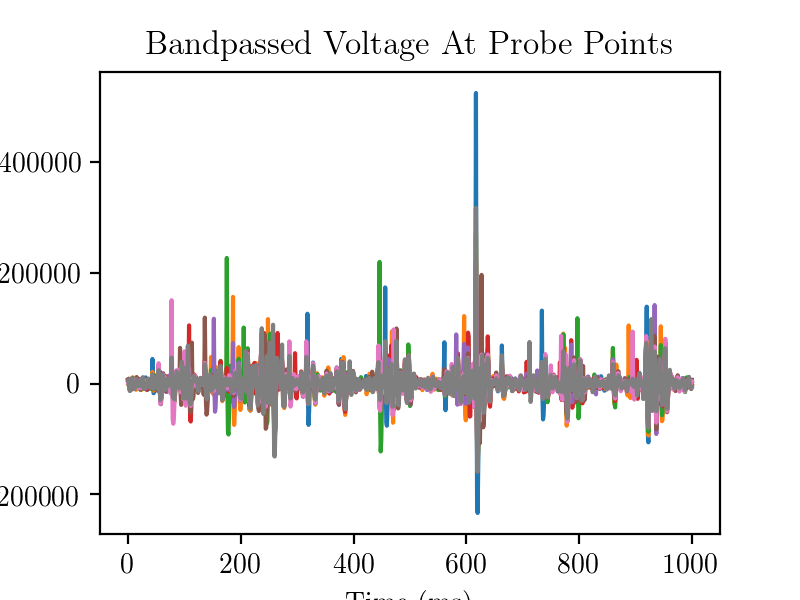

In [18]:
plt.figure(figsize=(4,3))
plt.plot(range(tmax), statesf)
plt.title('Bandpassed Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (kV)')
None

# Rudimentary Spike Sorting
Use the same simple threshold-based method as Keith to find the times of and intervals between the spikes.

In [19]:
def find_spikes(x):
    """
    Finds spikes, where the voltage dips below -20uV, 
    and returns their onset times.
    """
    return (np.diff(np.int32(x < -20e3), axis=0) == 1).nonzero()

In [20]:
spikes_per_channel = [find_spikes(statesf[:,channel])[0]
                     for channel in range(8)]

In [21]:
# Make a list of interspike intervals from all channels.
intervals = itertools.chain.from_iterable(
    [np.diff(spikes_per_channel[channel])
     for channel in range(8)])
intervals = np.array(list(intervals))

<IPython.core.display.Javascript object>


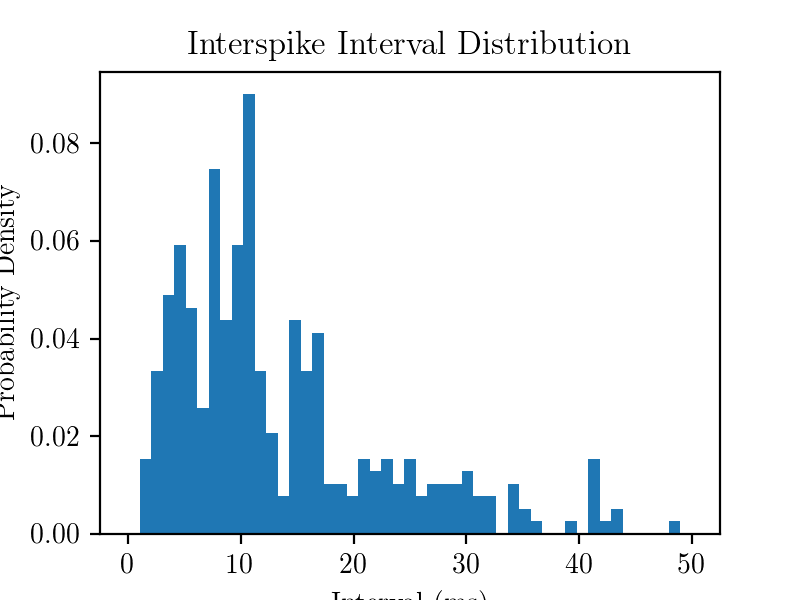

In [22]:
plt.figure(figsize=(4,3))
plt.hist(intervals, list(np.linspace(0,50)) + [np.inf], density=True)
plt.title('Interspike Interval Distribution')
plt.xlabel('Interval (ms)')
plt.ylabel('Probability Density')
None

# Probe Visualization
Just for fun, here's each cell colored according to which probe it's closest to and how much it contributes to that probe.

<IPython.core.display.Javascript object>


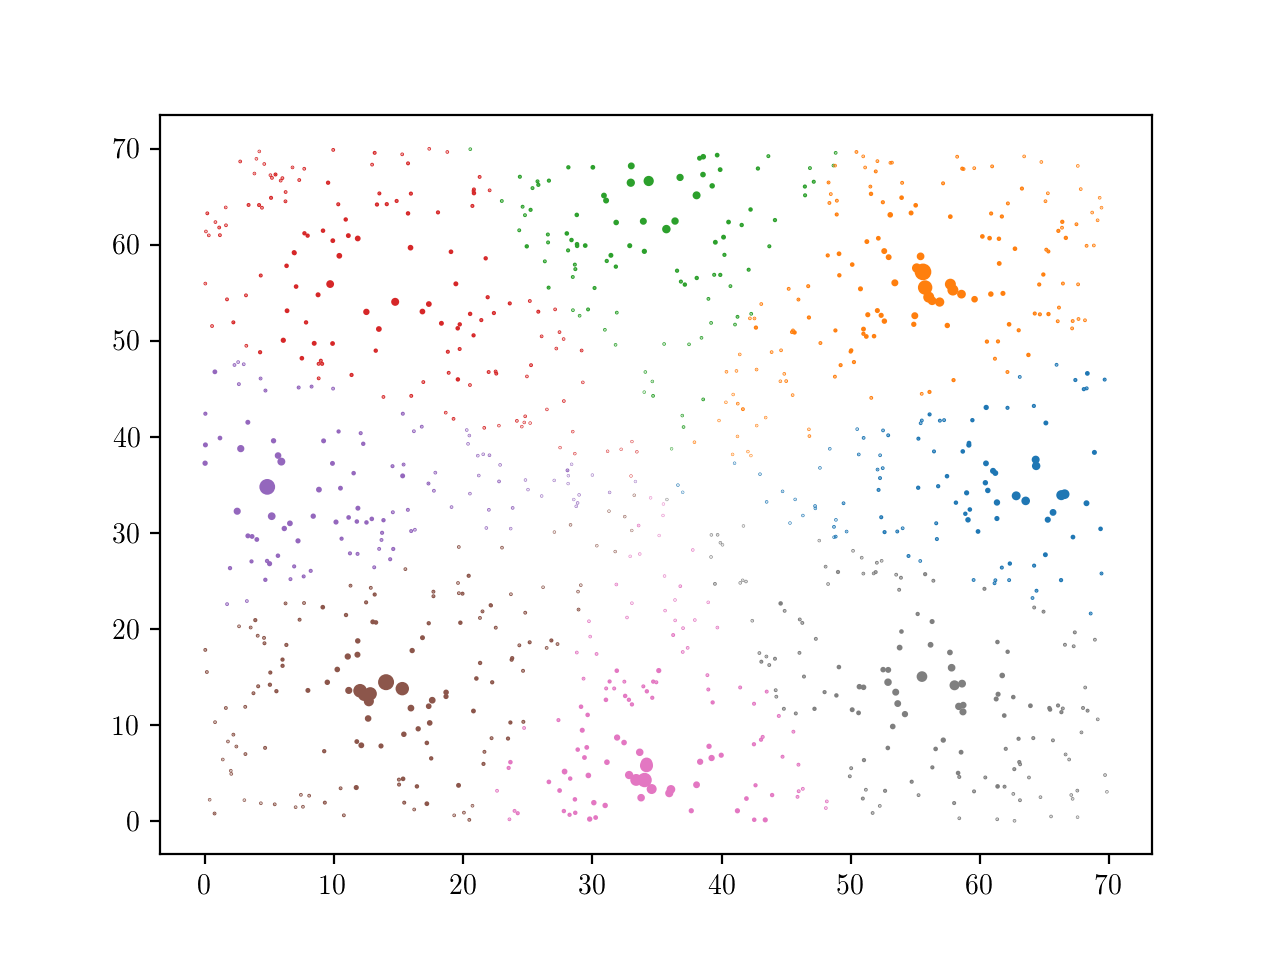

In [23]:
plt.figure()
iprobe = np.argmax(u.M, axis=1)
colors = ['C'+str(i) for i in iprobe]
plt.scatter(n.XY[0,:], n.XY[1,:], c=colors, 
            s=25 * np.max(u.M, axis=1) / np.max(u.M))